In [236]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
from pylatexenc import *
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import pulse                 
from qiskit.circuit import Parameter, Gate
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

In [237]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b329039fa5b6a51c48478ade21391d83ffbb0be7bf31d55287a80cfbca16ddf13669c14a278682edffa293f4ccda8a7e864ea8f2f1dec12c5b863e99eeac0b4c",overwrite=True)

In [238]:
# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [239]:
# Choose your backend
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

In [240]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.721909189206854 GHz.
Default anharmonicity is -0.31197865973435573 GHz.


In [241]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [242]:
# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

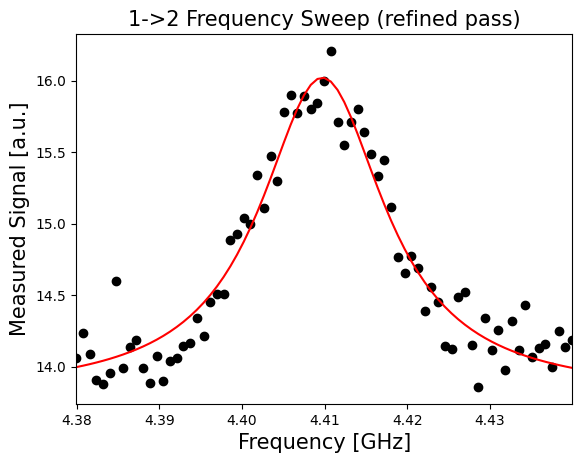

Our updated estimate for the 1->2 transition frequency is 4.4097115 GHz.


In [243]:
########discriminating states
#######################

####Computing the 1->2 frequency
##Excite the |1⟩ state by applying a 0 -> 1 π pulse. Then perform the frequency sweep over excitations of the |1⟩ state. 
##A single peak should be observed at a frequency lower than the 0 -> 1 frequency which corresponds to the 1 -> 2 frequency.
# smaller range sweep
num_freqs = 75
drive_power = 0.15
sweep_freqs = default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    with pulse.frequency_offset(freq, drive_chan):
        pulse.play(pulse.Gaussian(duration=x12_duration,
                                  amp=drive_power,
                                  sigma=x12_sigma,
                                  name='x12_pulse'), drive_chan)

spect_gate = Gate("spect", 1, [freq])

qc_spect = QuantumCircuit(1, 1)

qc_spect.x(0)
qc_spect.append(spect_gate, [0])
qc_spect.measure(0, 0)
qc_spect.add_calibration(spect_gate, (0,), freq12_sweep_sched, [freq])
    
exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

# excited_freq_sweep_job = backend.run(exp_spect_circs, 
#                                      meas_level=1, 
#                                      meas_return='avg', 
#                                      shots=NUM_SHOTS)

# job_monitor(excited_freq_sweep_job)

job_id = "cpnc5mp9nad0008prgxg"
# job_id = "cq8r9j6rr08g008sq960"
excited_freq_sweep_job = service.job(job_id)


# Get the refined data (average)
# plot and fit the refined signal, using the standard Lorentzian curve.
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-30*MHz, 30*MHz, num_freqs)

def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# do fit in Hz
(excited_sweep_fit_params, 
 excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
                                     excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-20, 4.721909189206854*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

In [244]:
#######1->2 Rabi Experiment
##############################
##perform a Rabi experiment to obtain the π pulse amplitude for the 1 -> 2 transition.
##To do so, we apply a 0 → 1 π pulse and then sweep over drive amplitudes at the 1 -> 2 frequency.

# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

amp = Parameter('amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=amp,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
    
rabi_gate = Gate("rabi", 1, [amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.x(0)
qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [amp])
    
exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

# rabi_12_job = backend.run(exp_rabi_circs, 
#                           meas_level=1, 
#                           meas_return='avg', 
#                           shots=NUM_SHOTS)

# job_monitor(rabi_12_job)

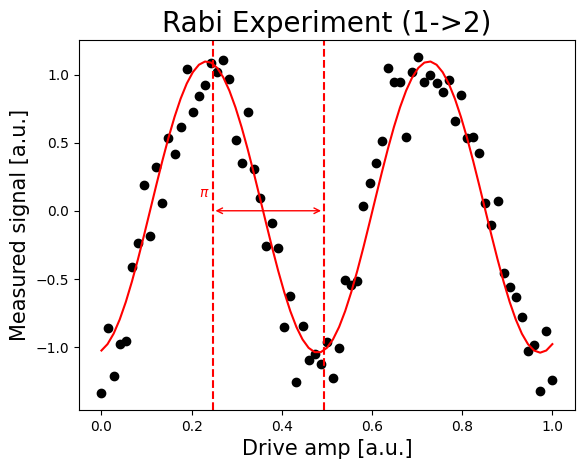

Our updated estimate for the 1->2 transition frequency is 4.4097115 GHz.
Pi Amplitude (1->2) = 0.2466186343423263


In [245]:
# Get the job data (average)
job_id = "cpnf0d99nad0008prpa0"
# job_id = "cq903kpcc620008m3kf0"
rabi_12_job = service.job(job_id)
rabi_12_data = get_job_data(rabi_12_job, average=True)

def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

# Note: Only real part of data is plotted
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                               rabi_12_data, 
                               lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                               [0.2, 0, 0.3, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2] 

pi_amp_12 = drive_12_period/2

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

In [246]:
#!pip3 install pylatexenc

In [247]:
n_a = 1 ## ancilla
n_l = 2 ## clock register
n_b = 1 ## input vector

In [248]:
ancilla = QuantumRegister(n_a, name='ancilla')
b = QuantumRegister(n_b, name='b')
clock = QuantumRegister(n_l, name='clock')
measurement = ClassicalRegister(2, name='c')

hhl = QuantumCircuit(ancilla, clock, b, measurement)
hhl.barrier(label='$\psi_0$')


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [249]:
## Build 1->2 pulse
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
x12_gate = Gate("one_two_pulse", 1, [])

In [250]:
## Put pulse on ancilla, ancilla is mapped to qubit 0 in the hardware

hhl.x(ancilla)
hhl.append(x12_gate, [0])
hhl.add_calibration(x12_gate, (0,), x12_sched, [])
hhl.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [251]:
hhl.x(b)
hhl.barrier(label='$\psi_1$')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [252]:
hhl.h(clock)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')
hhl.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [253]:
hhl.h(clock[1])
hhl.cp(-np.pi/2, clock[0], clock[1])
hhl.h(clock[0])
hhl.swap(clock[0], clock[1])
hhl.barrier(label='$\psi_2$')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [254]:
hhl.cry(pi, clock[0], ancilla)
hhl.cry(pi/3, clock[1], ancilla)
hhl.barrier(label='$\psi_3$')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [255]:
hhl.measure(ancilla, measurement[0])
hhl.barrier(label='$\psi_4$')


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [256]:
hhl.swap(clock[0], clock[1])
hhl.h(clock[0])
hhl.cp(np.pi/2, clock[0], clock[1])
hhl.h(clock[1])
hhl.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [257]:
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
hhl.h(clock)
hhl.barrier(label='$\psi_5$')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=4, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'ancilla'), 0), Qubit(QuantumRegister(2, 'clock'), 0), Qubit(QuantumRegister(2, 'clock'), 1), Qubit(QuantumRegister(1, 'b'), 0)), clbits=())

In [258]:
hhl.measure(b,measurement[1])

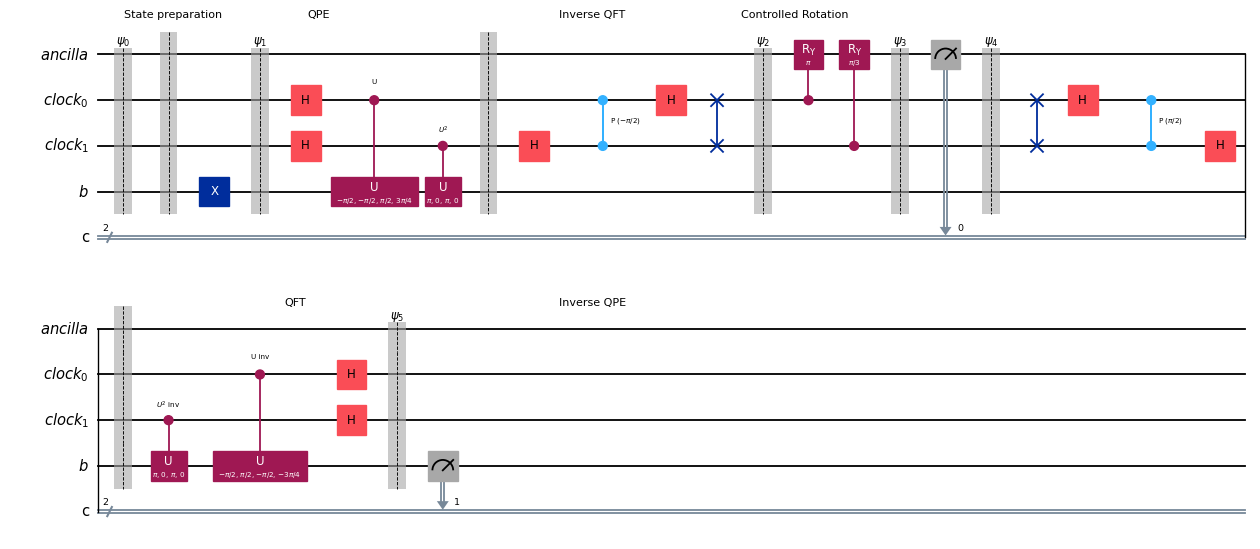

In [259]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
height = 0.8
ax.text(0.5, height, 'State preparation', size=8)
ax.text(4.5, height, 'QPE', size=8)
ax.text(10, height, 'Inverse QFT', size=8)
ax.text(14, height, 'Controlled Rotation', size=8)
ax.text(4, -5.5, 'QFT', size=8)
ax.text(10, -5.5, 'Inverse QPE', size=8)
hhl.draw('mpl', ax=ax)


In [260]:
## simulator

9.333333333333334


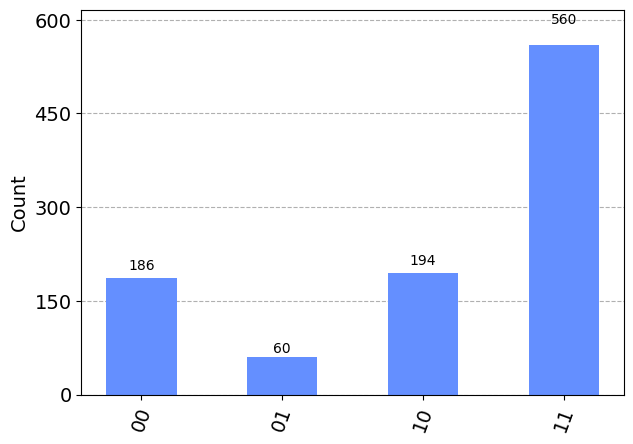

In [270]:
nShots = 1000
backend = BasicProvider().get_backend('basic_simulator')
# perform constant_full_circuit just 1 time and plot the histogram of states!
hhl_tr = transpile(hhl, backend)
job = backend.run(hhl_tr, shots = nShots)
result = job.result()
counts=result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts)
# print(counts['00']/nShots)
# print(counts['10']/nShots)


In [262]:
### ibm hardware

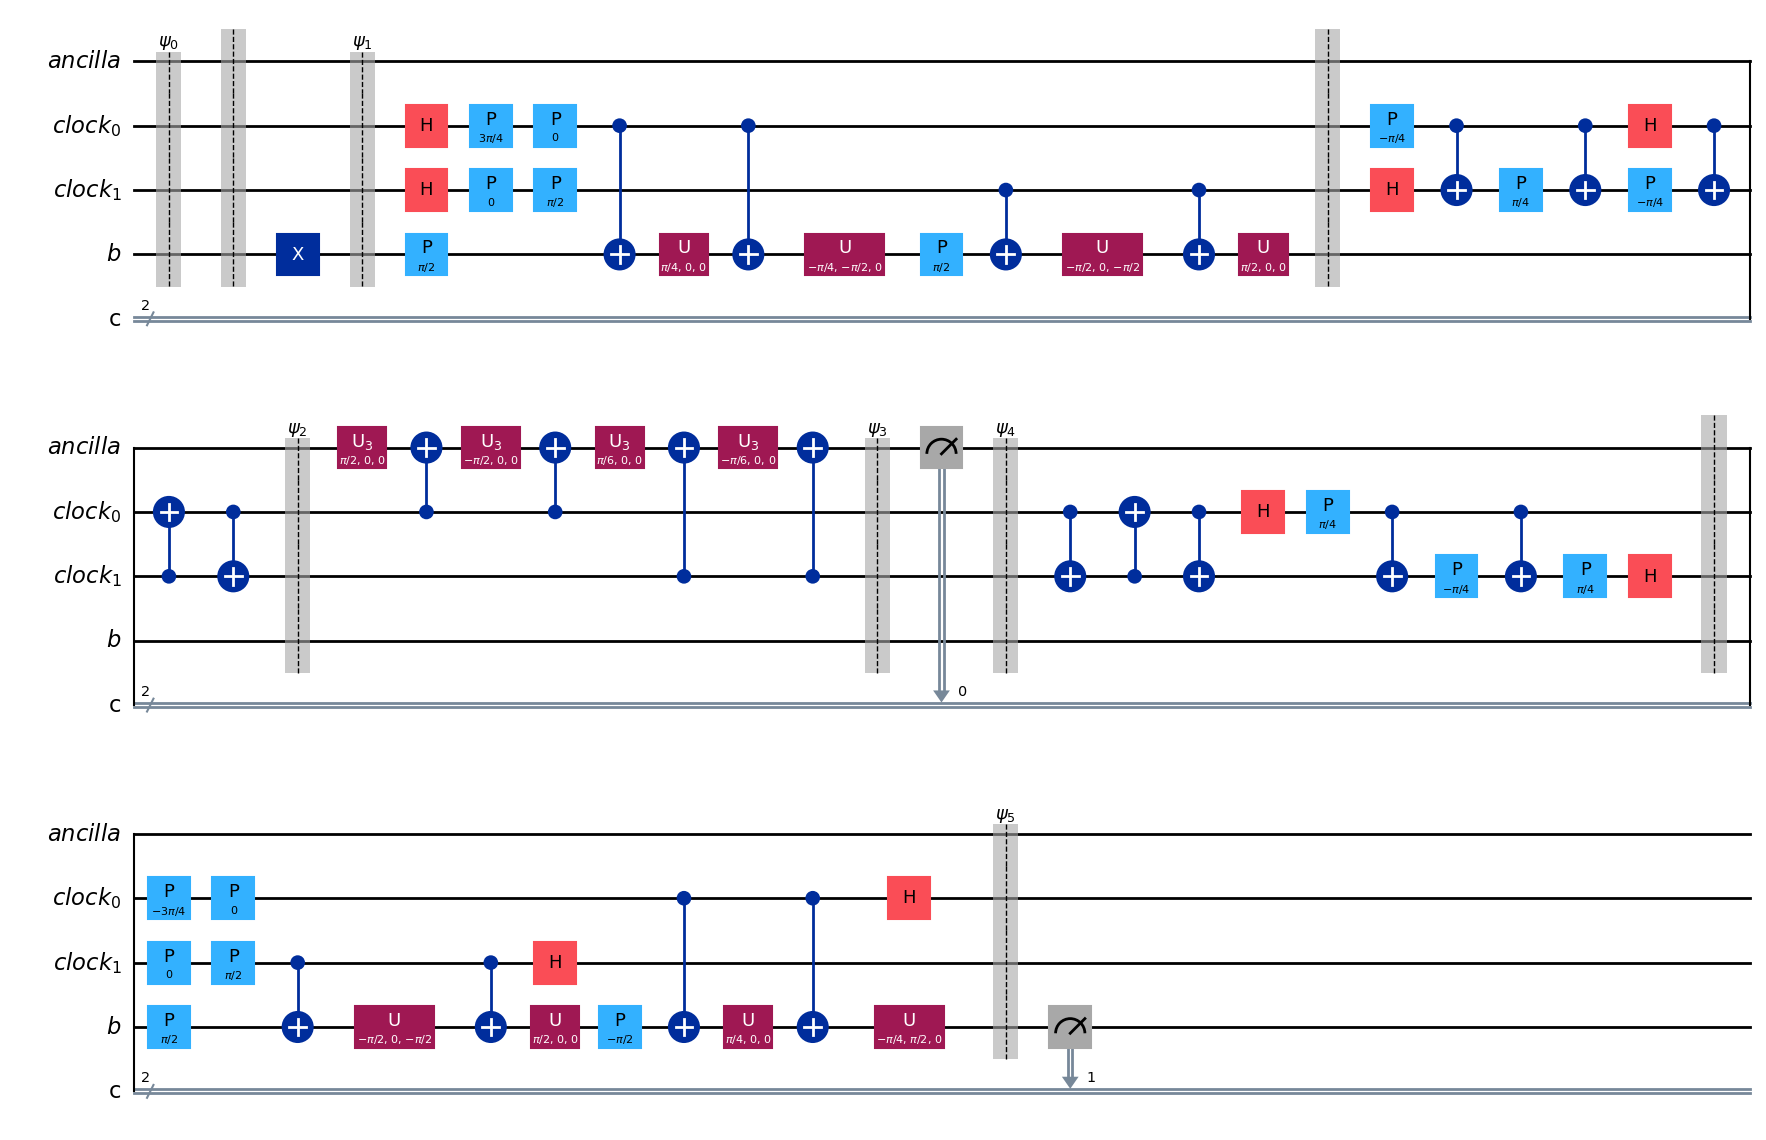

In [263]:
nShots = 1000
hhl_tr = transpile(hhl, backend, layout_method='trivial', optimization_level=0)

# hhl_tr.draw(output='mpl', idle_wires=False)

In [264]:
# job = backend.run([hhl_tr], 
#                   meas_level=2, 
#                   meas_return='single', 
#                   shots=nShots)
# job_monitor(job)

0.9182156133828996


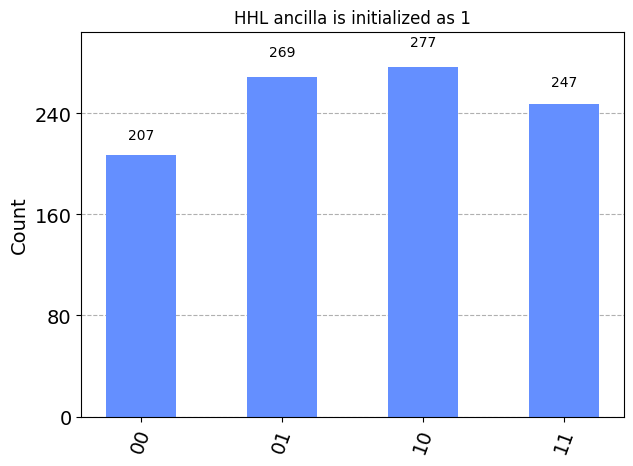

In [271]:
job_id = "ctz377cg22kg0084t4mg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts, title='HHL ancilla is initialized as 1')

1.1424936386768447


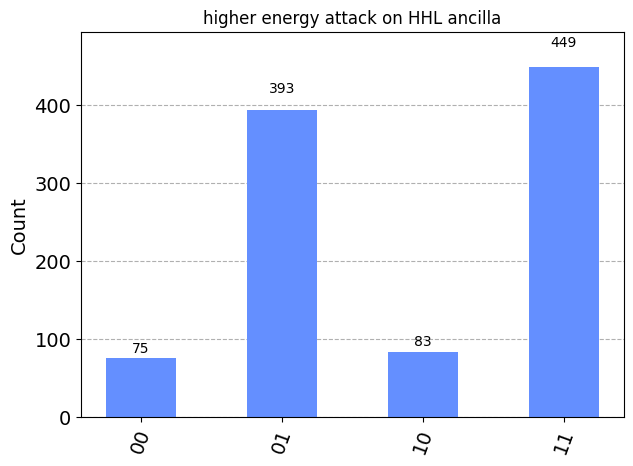

In [272]:
job_id = "ctz31qpvz5fg0081c770"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts, title='higher energy attack on HHL ancilla')

1.5625


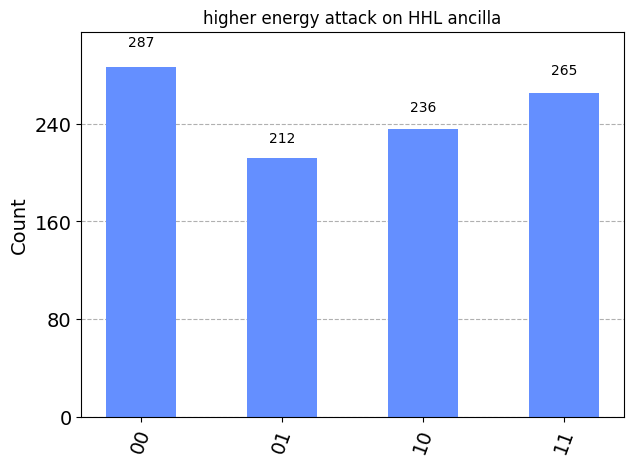

In [267]:
job_id = "ctz23hpfhad0008tk3r0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(((counts['11'])**2)/((counts['01'])**2))
plot_histogram(counts, title='higher energy attack on HHL ancilla')

1.5857338820301783


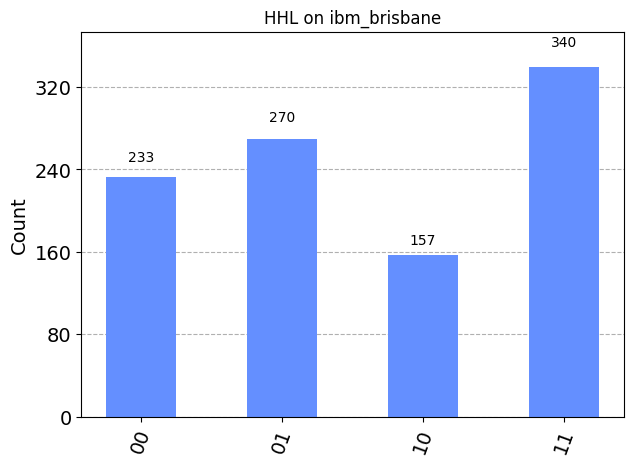

In [268]:
job_id = "ctz1re9h4j1g0082sc30"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(((counts['11'])**2)/((counts['01'])**2))
plot_histogram(counts, title='HHL on ibm_brisbane')